In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import random_rotation

2023-11-26 23:34:44.754632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 23:34:44.878202: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 23:34:45.472548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-26 23:34:45.472634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import tensorflow as tf
    
class Rotate90Randomly(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self):
        super(Rotate90Randomly, self).__init__()

    def call(self, x, training=False):
        def random_rotate():
            rotation_factor = tf.random.uniform([], minval=1,
                                                maxval=3, dtype=tf.int32)
            return tf.image.rot90(x, k=rotation_factor)

        training = tf.constant(training, dtype=tf.bool)
        
        rotated = tf.cond(training, random_rotate, lambda: x)
        rotated.set_shape(rotated.shape)
        return rotated
class RandomFlipOnProbability(tf.keras.layers.Layer):
  def __init__(self, probability):
    super(RandomFlipOnProbability, self).__init__()
    self.probability = probability

  def call(self, images):
    return tf.cond(tf.random.uniform(()) < self.probability, lambda: tf.image.flip_left_right(images), lambda: images)

In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import RandomRotation,RandomFlip
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers
import math
train_dataset_path ='corona_data/Dataset/xray_dataset_covid19/train'
batch_size = 10
image_size =  (150,150)
validation_split = 0.1
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=50,
    image_size=image_size,
    batch_size=batch_size)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=50,
    shuffle=True,  
    image_size=image_size,
    batch_size=batch_size)

test_datapath ='corona_data/Dataset/xray_dataset_covid19/test'
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_datapath,
    seed=123,  # Use the same seed as training dataset
    image_size=image_size,
    batch_size=batch_size)

train_dataset_1=train_dataset
# train_dataset.shuffle(15, reshuffle_each_iteration=True)

Found 148 files belonging to 2 classes.
Using 14 files for validation.
Found 148 files belonging to 2 classes.
Using 134 files for training.
Found 40 files belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def rotate_dataset(dataset, degrees):
    rotation_layer = RandomRotation(factor=degrees/360, fill_mode='reflect')
    return dataset.map(lambda x, y: (rotation_layer(x, training=True), y))

def flip_dataset(dataset):
    flip_layer = RandomFlip('horizontal')
    return dataset.map(lambda x, y: (flip_layer(x, training=True), y))

# Augment and concatenate the datasets
def augment_and_concatenate(original_dataset):
    rotated_90 = rotate_dataset(original_dataset, 90)
    rotated_180 = rotate_dataset(original_dataset, 180)
    rotated_270 = rotate_dataset(original_dataset, 270)
    flipped = flip_dataset(original_dataset)


    # Concatenate the original dataset with augmented data
    augmented_dataset = original_dataset.concatenate(rotated_90).concatenate(rotated_180).concatenate(rotated_270).concatenate(flipped)
    return augmented_dataset
train_dataset=augment_and_concatenate(train_dataset)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
def build_cnn_model():
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(150, 150, 3)))
    # model.add(data_augmentation)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Convolutional Layer 4
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Convolutional Layer 5
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Convolutional Layer 6
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())

    # Fully connected Layer 1
    model.add(Dense(512))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    # Fully connected Layer 2
    model.add(Dense(256))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification: COVID-19 or Normal

    # Compile the model
    adam_optimizer = Adam()
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 75, 75, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)       

In [27]:
with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(train_dataset,epochs=1,batch_size=150,validation_data=validation_dataset)
    cnn_model.save_weights("coron_weights.keras")

14/14 [==============================] - 1s 57ms/step - loss: 0.0211 - accuracy: 0.9925 - val_loss: 0.2321 - val_accuracy: 0.7857


In [17]:
# %%
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
from time import time
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator ,load_img
from PIL import Image
import os
import numpy as np
import random as rand
import shutil

def get_all_labels(dataset):
    all_labels = []

    for _, labels in dataset:
        all_labels.append(labels.numpy())

    return np.concatenate(all_labels)

def report(validation_dataset,model,model_history):
        class_labels = validation_dataset.class_names
        actual_labels = get_all_labels(validation_dataset)
        num_samples = len(actual_labels)
        num_classes = 2
        predicted_labels = model.predict(validation_dataset).round()
        report = classification_report(actual_labels, predicted_labels, target_names=class_labels)
        print(report)
        assert len(predicted_labels) == len(actual_labels)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(model_history.history['accuracy'], label='Train Accuracy')
        plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.subplot(1, 2, 2)
        plt.plot(model_history.history['loss'], label='Train Loss')
        plt.plot(model_history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

        plt.show()
        def plot_confusion_matrix(cm, classes,
                                normalize=False,
                                title='Confusion matrix',
                                cmap=plt.cm.Greens):
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                print("Normalized confusion matrix")
            else:
                print('Confusion matrix, without normalization')
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
            def generate_roc_curves(labels,y_pred,y_true):
                for (label_int,label) in enumerate(class_labels):
                    fpr, tpr, _ = roc_curve( y_true,y_pred,pos_label=label_int) 
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic Example ' +  label)
                    plt.legend(loc="lower right")
                    plt.show()
            generate_roc_curves(class_labels,predicted_labels,actual_labels)
        plt.figure(figsize=(10,10))
        cm = confusion_matrix(actual_labels, predicted_labels)
        plot_confusion_matrix(cm, classes=class_labels)


2/2 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

       COVID       0.50      0.40      0.44         5
      NORMAL       0.70      0.78      0.74         9

    accuracy                           0.64        14
   macro avg       0.60      0.59      0.59        14
weighted avg       0.63      0.64      0.63        14



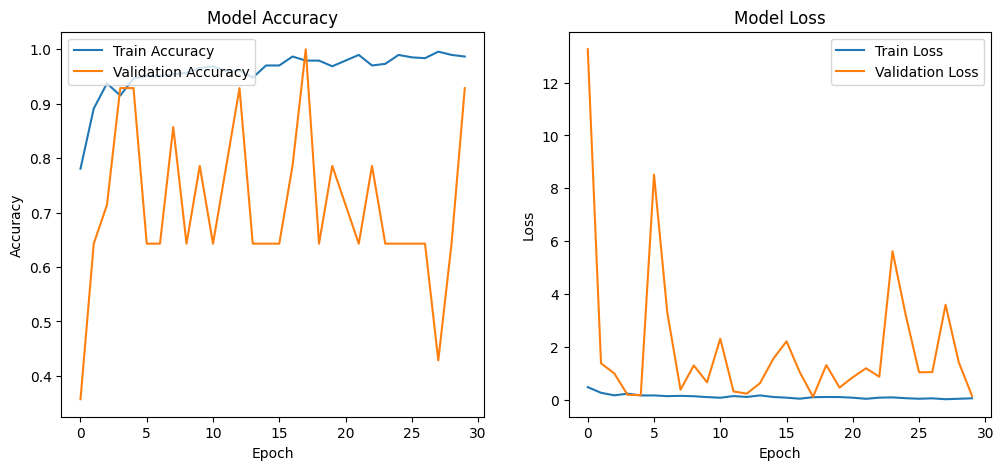

Confusion matrix, without normalization


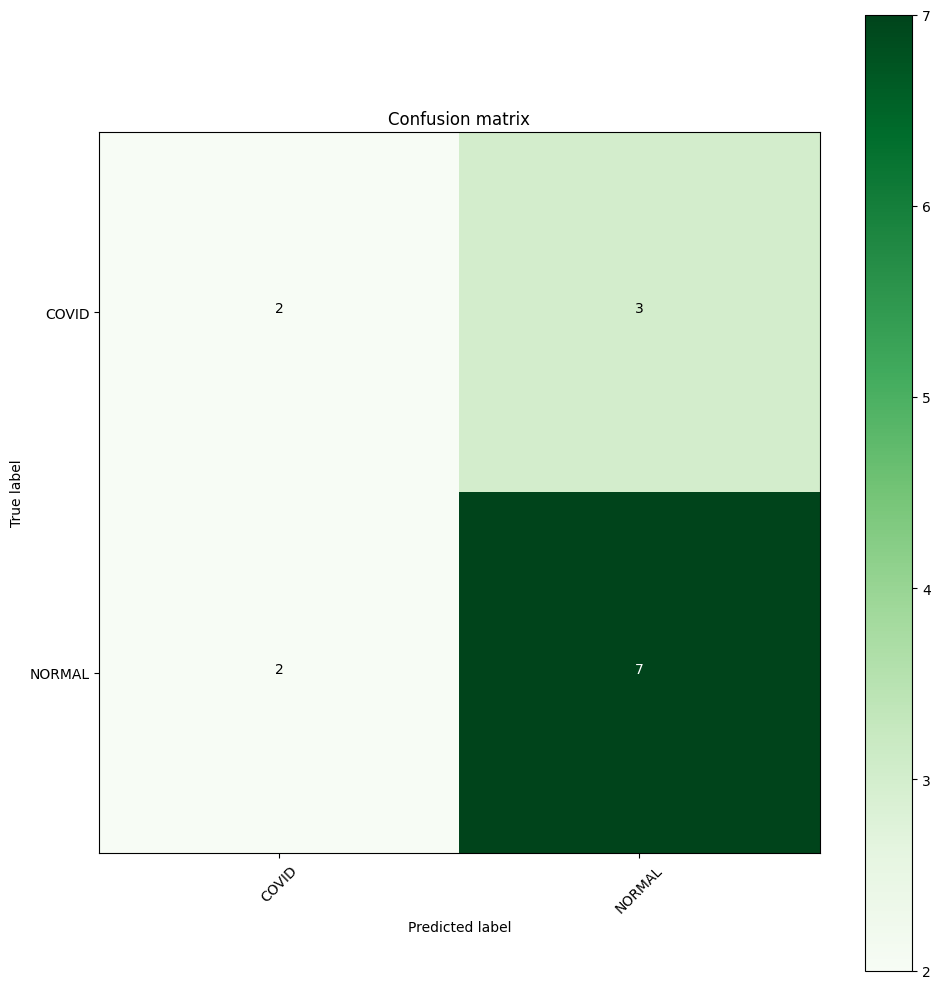

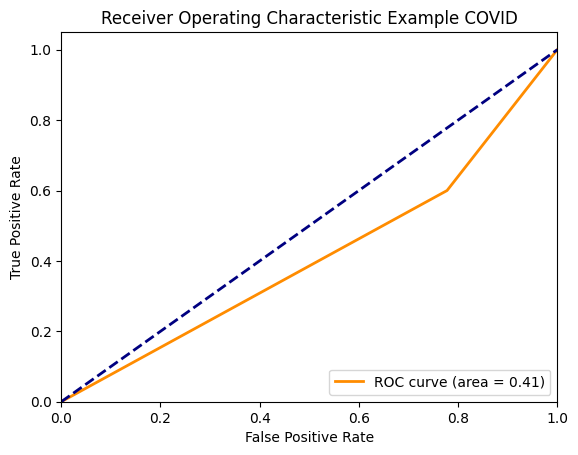

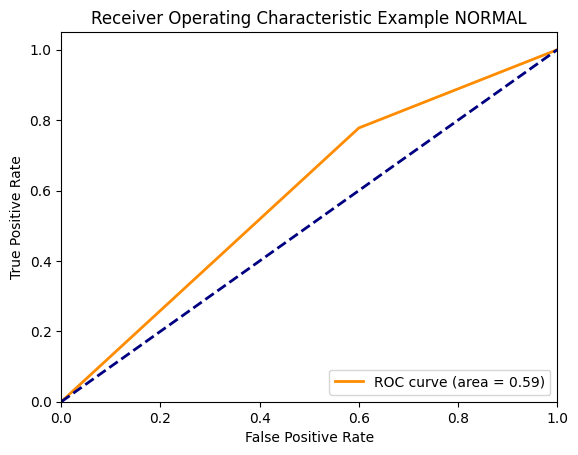

In [21]:
report(validation_dataset,cnn_model,cnn_history)

14/14 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

       COVID       0.48      0.42      0.45        69
      NORMAL       0.46      0.52      0.49        65

    accuracy                           0.47       134
   macro avg       0.47      0.47      0.47       134
weighted avg       0.47      0.47      0.47       134



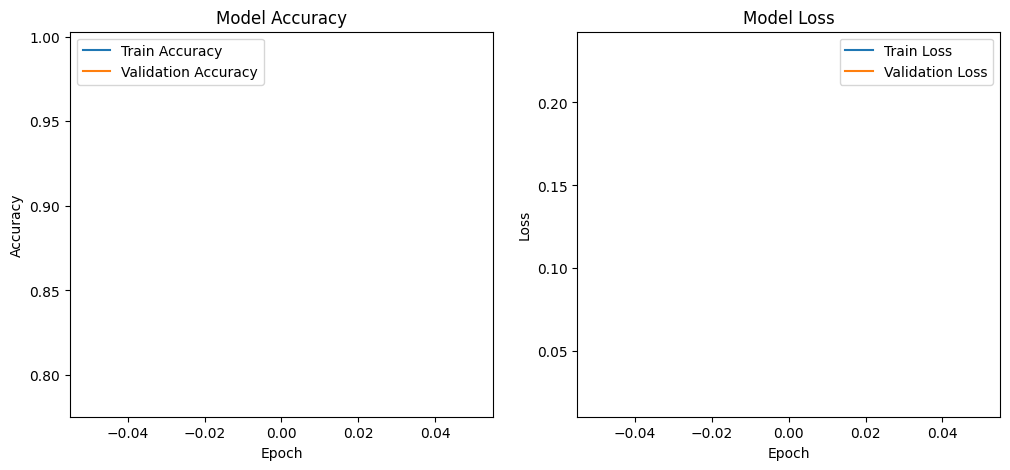

Confusion matrix, without normalization


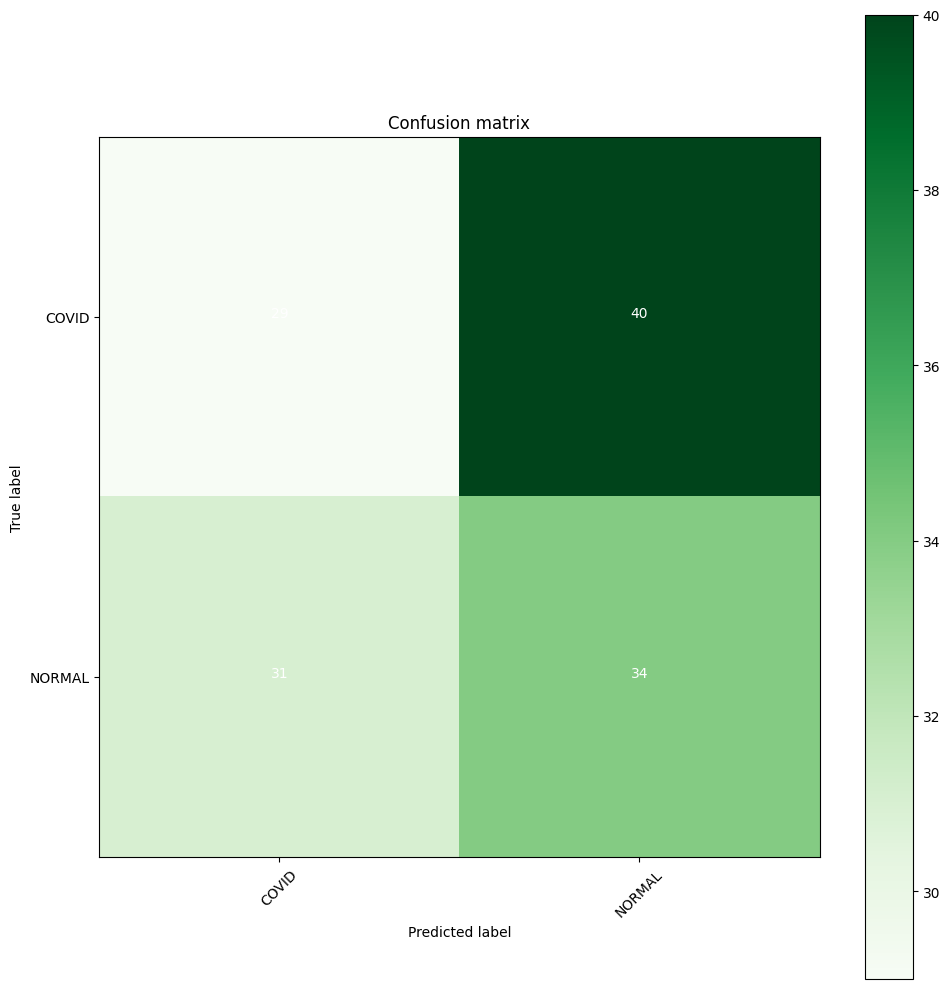

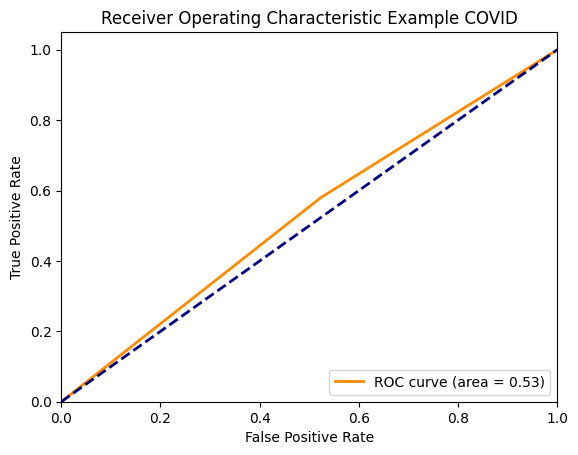

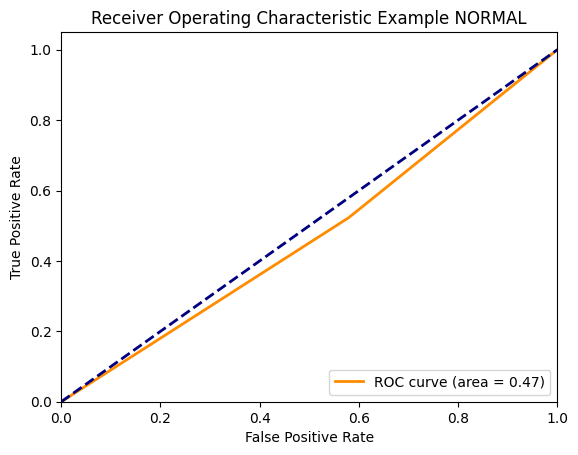

In [30]:
report(train_dataset_1,cnn_model,cnn_history)

4/4 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

       COVID       0.35      0.30      0.32        20
      NORMAL       0.39      0.45      0.42        20

    accuracy                           0.38        40
   macro avg       0.37      0.38      0.37        40
weighted avg       0.37      0.38      0.37        40



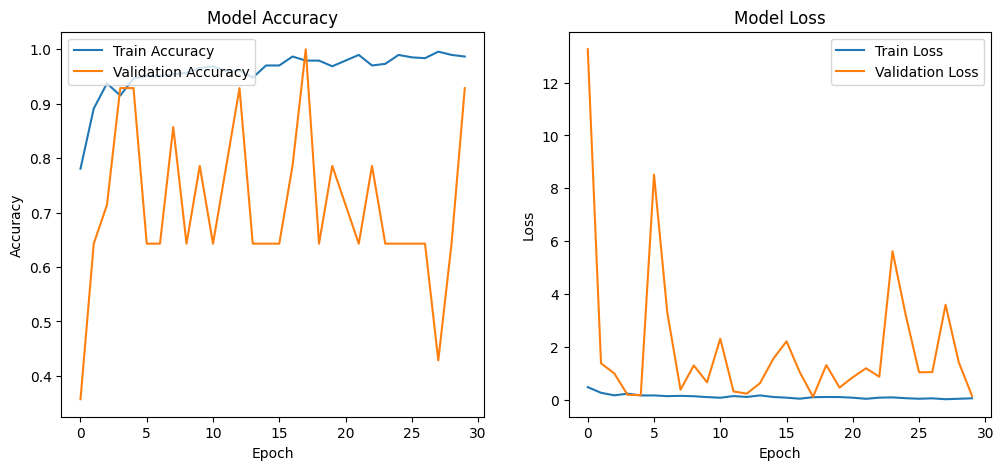

Confusion matrix, without normalization


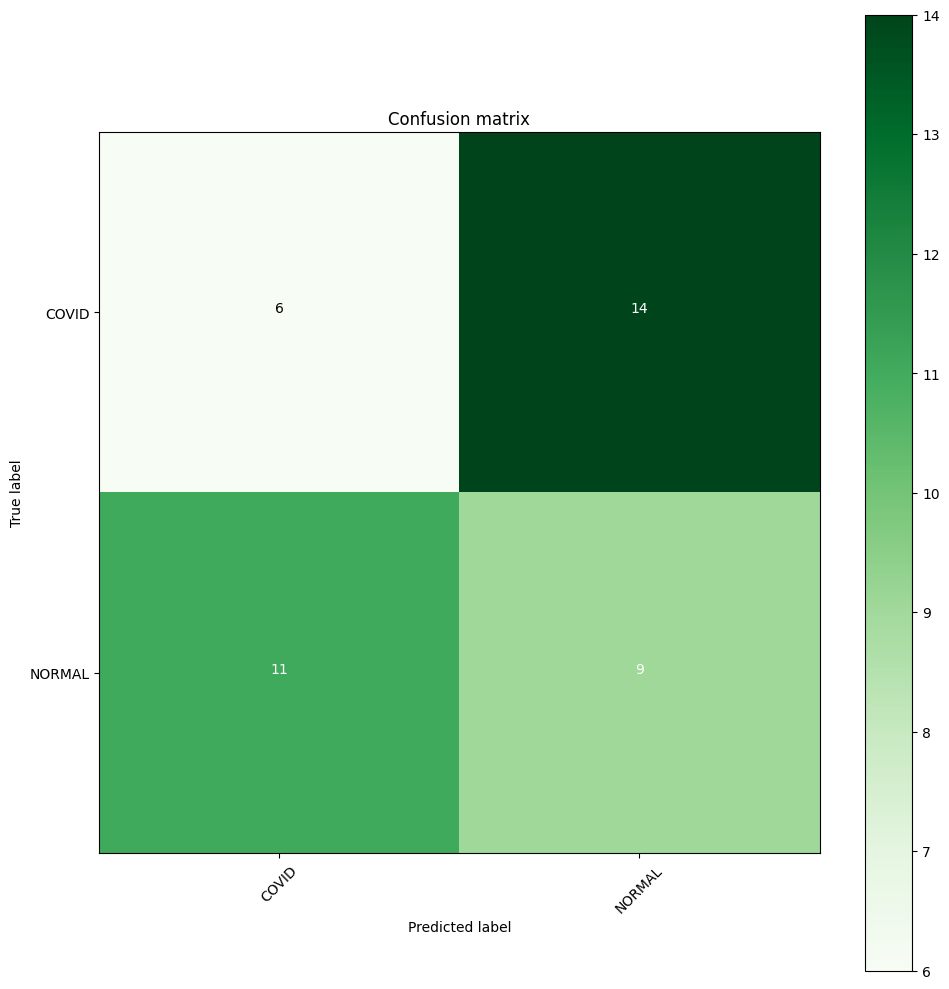

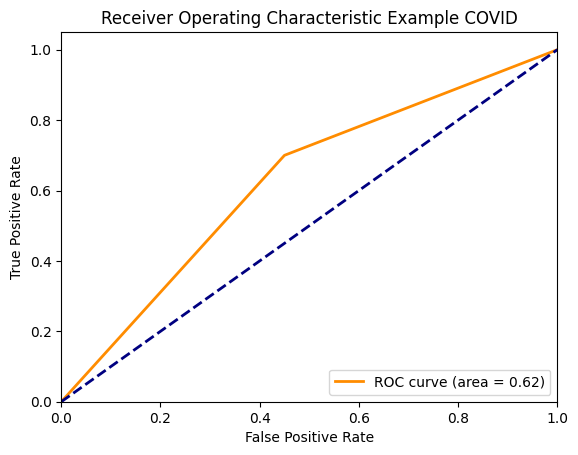

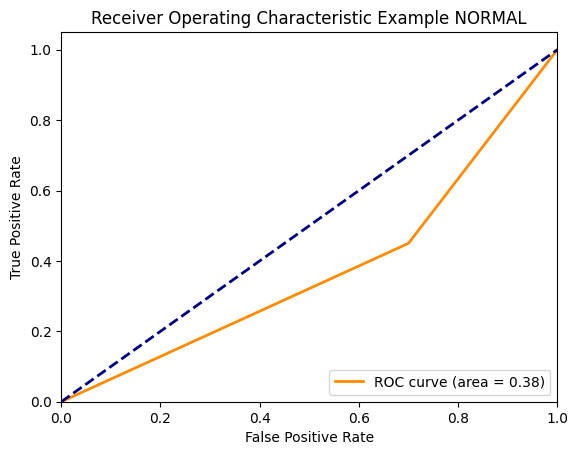

In [24]:
report(test_dataset,cnn_model,cnn_history)